#### Oğuz Deniz 201401011
##### YAP441 Project - Metaheuristics Approaches Notebook

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [17]:
class GeneticAlgorithmPredictor:
    def __init__(self, window_size=5, pop_size=50, generations=100, 
                 mutation_rate=0.1, crossover_rate=0.7, tournament_size=3, random_seed=None):
        """
        window_size: Number of past returns used as features.
        pop_size: Population size.
        generations: Number of generations to run.
        mutation_rate: Probability of mutating each gene.
        crossover_rate: Probability of performing crossover.
        tournament_size: Number of individuals used in tournament selection.
        random_seed: Optional seed for reproducibility.
        """
        self.window_size = window_size
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.best_individual = None
        self.best_fitness = -np.inf
        
        if random_seed is not None:
            np.random.seed(random_seed)

    def prepare_dataset(self, returns):
        """
        Creates a dataset using a sliding window. Each sample is formed by the
        previous 'window_size' returns, and the target is the direction of the next return.
        """
        X = []
        y = []
        for i in range(self.window_size, len(returns)):
            X.append(returns[i - self.window_size:i])
            # target: 1 if current return is positive, else 0.
            y.append(1 if returns[i] > 0 else 0)
        return np.array(X), np.array(y)

    def initialize_population(self):
        """
        Each individual is represented by (window_size + 1) real numbers: 
        'window_size' weights and one bias. The genes are initialized uniformly in [-1, 1].
        """
        population = []
        for _ in range(self.pop_size):
            individual = np.random.uniform(-1, 1, size=(self.window_size + 1,))
            population.append(individual)
        return population

    def fitness(self, individual, X, y):
        """
        Fitness is defined as the directional accuracy on the training data.
        """
        weights = individual[:self.window_size]
        bias = individual[-1]
        # Compute predictions for each sample
        pred = np.dot(X, weights) + bias
        predictions = (pred > 0).astype(int)
        accuracy = np.mean(predictions == y)
        return accuracy

    def tournament_selection(self, population, fitnesses):
        """
        Select one individual from the population using tournament selection.
        """
        candidates_idx = np.random.choice(len(population), self.tournament_size, replace=False)
        best_candidate = max(candidates_idx, key=lambda idx: fitnesses[idx])
        return population[best_candidate]

    def select_population(self, population, fitnesses):
        """
        Create a new population by selecting individuals via tournament selection.
        """
        new_population = []
        for _ in range(self.pop_size):
            new_population.append(self.tournament_selection(population, fitnesses))
        return new_population

    def crossover(self, parent1, parent2):
        """
        One-point crossover.
        """
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:point], parent2[point:]))
            child2 = np.concatenate((parent2[:point], parent1[point:]))
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()

    def mutate(self, individual):
        """
        Each gene is mutated with probability mutation_rate by adding a small Gaussian noise.
        """
        for i in range(len(individual)):
            if np.random.rand() < self.mutation_rate:
                individual[i] += np.random.normal(0, 0.1)
        return individual

    def evolve(self, X, y):
        """
        Run the genetic algorithm evolution process.
        """
        population = self.initialize_population()
        best = None
        best_fit = -np.inf
        
        for gen in range(self.generations):
            fitnesses = [self.fitness(ind, X, y) for ind in population]
            # Keep track of the best individual found so far.
            gen_best_idx = np.argmax(fitnesses)
            if fitnesses[gen_best_idx] > best_fit:
                best_fit = fitnesses[gen_best_idx]
                best = population[gen_best_idx].copy()
            
            # Selection
            selected_population = self.select_population(population, fitnesses)
            
            # Create next generation via crossover and mutation.
            next_generation = []
            for i in range(0, self.pop_size, 2):
                parent1 = selected_population[i]
                if i + 1 < self.pop_size:
                    parent2 = selected_population[i+1]
                else:
                    parent2 = selected_population[0]
                child1, child2 = self.crossover(parent1, parent2)
                next_generation.append(self.mutate(child1))
                next_generation.append(self.mutate(child2))
            population = next_generation[:self.pop_size]
        
        self.best_individual = best
        self.best_fitness = best_fit

    def predict(self, X):
        """
        Predict using the best individual found. Returns binary predictions.
        """
        if self.best_individual is None:
            raise ValueError("The GA has not been run. Call 'evolve' first.")
        weights = self.best_individual[:self.window_size]
        bias = self.best_individual[-1]
        pred = np.dot(X, weights) + bias
        predictions = (pred > 0).astype(int)
        return predictions


# =============================================================================
# Data Preparation (Shared by All Models)
# =============================================================================

def prepare_data(data):
    """
    Cleans the data, ensures the Date is datetime, sets it as the index,
    and calculates daily returns based on the 'Adj Close' column.
    """
    data = data.copy()
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    data['Returns'] = data['Adj Close'].pct_change()
    data = data.dropna()
    return data

In [18]:
def evaluate_genetic_algorithm_predictions(data, window_size=5, test_size=0.2,
                                             pop_size=50, generations=100, mutation_rate=0.1,
                                             crossover_rate=0.7, tournament_size=3, random_seed=None):
    """
    Evaluates the GA-based predictor on the data.
    Splits the data into training and testing parts, uses the GA to optimize a linear model
    on the training set, and then evaluates the directional accuracy on the test set.
    Returns a dictionary with metrics and predictions.
    """
    df = prepare_data(data)
    returns = df['Returns'].values

    # Create dataset using a sliding window.
    ga_predictor = GeneticAlgorithmPredictor(window_size=window_size, pop_size=pop_size, 
                                               generations=generations, mutation_rate=mutation_rate,
                                               crossover_rate=crossover_rate, tournament_size=tournament_size,
                                               random_seed=random_seed)
    X, y = ga_predictor.prepare_dataset(returns)
    
    # Split dataset into training and test sets.
    split_idx = int(len(X) * (1 - test_size))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]
    
    # Evolve the population on the training data.
    ga_predictor.evolve(X_train, y_train)
    
    # Predict on the test set.
    predictions = ga_predictor.predict(X_test)
    
    # Evaluation metrics.
    accuracy = accuracy_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    print("Genetic Algorithm Predictor Results:")
    print(f"GA Best Training Accuracy (fitness): {ga_predictor.best_fitness:.2%}")
    print(f"Test Directional Accuracy: {accuracy:.2%}")
    print(f"Test Mean Squared Error: {mse:.4f}")
    print(f"Test Mean Absolute Error: {mae:.4f}")
    
    # Scatter plot for predictions (dots) over test dates.
    test_dates = df.iloc[window_size + split_idx:].index  # Adjust index due to sliding window offset.
    plt.figure(figsize=(12, 6))
    plt.scatter(test_dates, y_test, label='Actual Direction', color='blue', marker='o')
    plt.scatter(test_dates, predictions, label='Predicted Direction', color='red', marker='x')
    plt.xlabel("Date")
    plt.ylabel("Direction (1 = Up, 0 = Down)")
    plt.title("Genetic Algorithm Predictor: Actual vs. Predicted Direction (Test Set)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'mse': mse,
        'mae': mae,
        'predictions': predictions,
        'actual': y_test,
        'best_individual': ga_predictor.best_individual,
        'ga_config': {
            'window_size': window_size,
            'pop_size': pop_size,
            'generations': generations,
            'mutation_rate': mutation_rate,
            'crossover_rate': crossover_rate,
            'tournament_size': tournament_size
        }
    }

In [19]:
def run_genetic_algorithm_experiments(data):
    """
    Runs the GA predictor with different hyperparameter configurations.
    Returns a dictionary with the results for each configuration.
    """
    configs = [
        # You can adjust or add more configurations as desired.
        {'pop_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'crossover_rate': 0.7, 'tournament_size': 3},
        {'pop_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'crossover_rate': 0.7, 'tournament_size': 3},
        {'pop_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'crossover_rate': 0.7, 'tournament_size': 3},
        {'pop_size': 50, 'generations': 100, 'mutation_rate': 0.2, 'crossover_rate': 0.7, 'tournament_size': 3},
        {'pop_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'crossover_rate': 0.9, 'tournament_size': 3},
    ]
    
    results = {}
    for i, config in enumerate(configs):
        print("\n======================================================")
        print(f"Running GA Experiment {i+1} with config: {config}")
        result = evaluate_genetic_algorithm_predictions(
            data,
            window_size=5,
            test_size=0.2,
            pop_size=config['pop_size'],
            generations=config['generations'],
            mutation_rate=config['mutation_rate'],
            crossover_rate=config['crossover_rate'],
            tournament_size=config['tournament_size'],
            random_seed=42  # for reproducibility
        )
        key = f"GA_exp_{i+1}_pop{config['pop_size']}_gen{config['generations']}_mut{config['mutation_rate']}_cross{config['crossover_rate']}"
        results[key] = result
    return results

def plot_ga_accuracies(results):
    """
    Prints and plots the test directional accuracy values for all GA experiments.
    """
    model_names = list(results.keys())
    accuracies = [results[k]['accuracy'] for k in model_names]
    
    # Print results.
    print("\nGenetic Algorithm Experiment Accuracies:")
    for name, acc in zip(model_names, accuracies):
        print(f"{name}: {acc:.2%}")
    
    # Plot results.
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='orchid')
    plt.ylabel("Test Directional Accuracy")
    plt.xlabel("GA Experiment Configuration")
    plt.title("GA Predictor Accuracies for Different Hyperparameter Settings")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


Running GA Experiment 1 with config: {'pop_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'crossover_rate': 0.7, 'tournament_size': 3}
Genetic Algorithm Predictor Results:
GA Best Training Accuracy (fitness): 53.26%
Test Directional Accuracy: 51.38%
Test Mean Squared Error: 0.4862
Test Mean Absolute Error: 0.4862


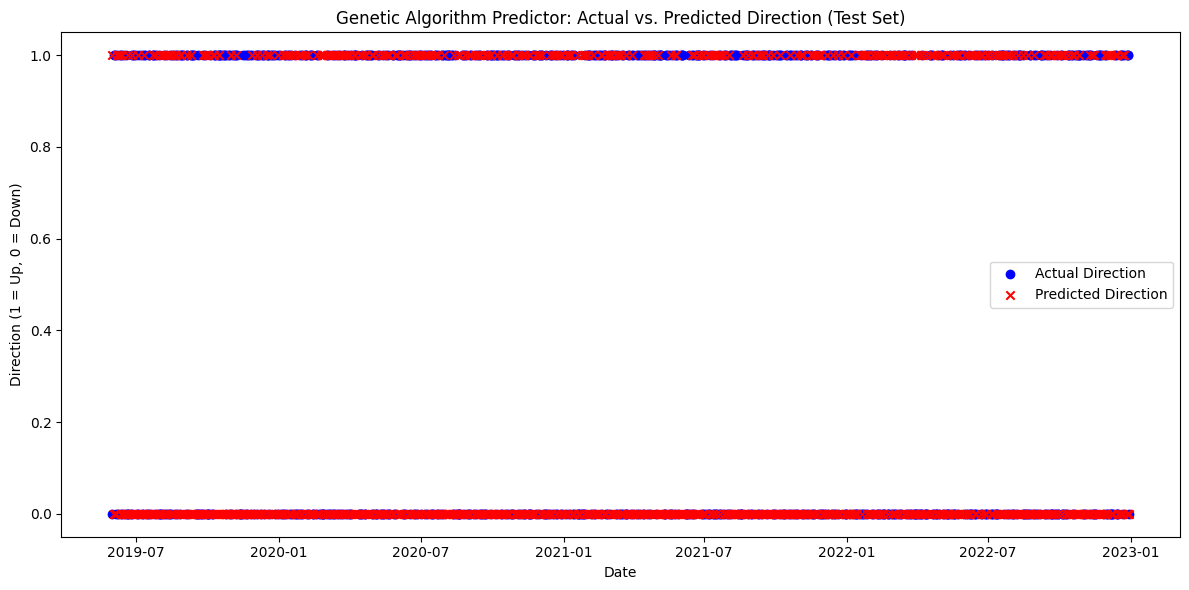


Running GA Experiment 2 with config: {'pop_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'crossover_rate': 0.7, 'tournament_size': 3}
Genetic Algorithm Predictor Results:
GA Best Training Accuracy (fitness): 53.04%
Test Directional Accuracy: 49.28%
Test Mean Squared Error: 0.5072
Test Mean Absolute Error: 0.5072


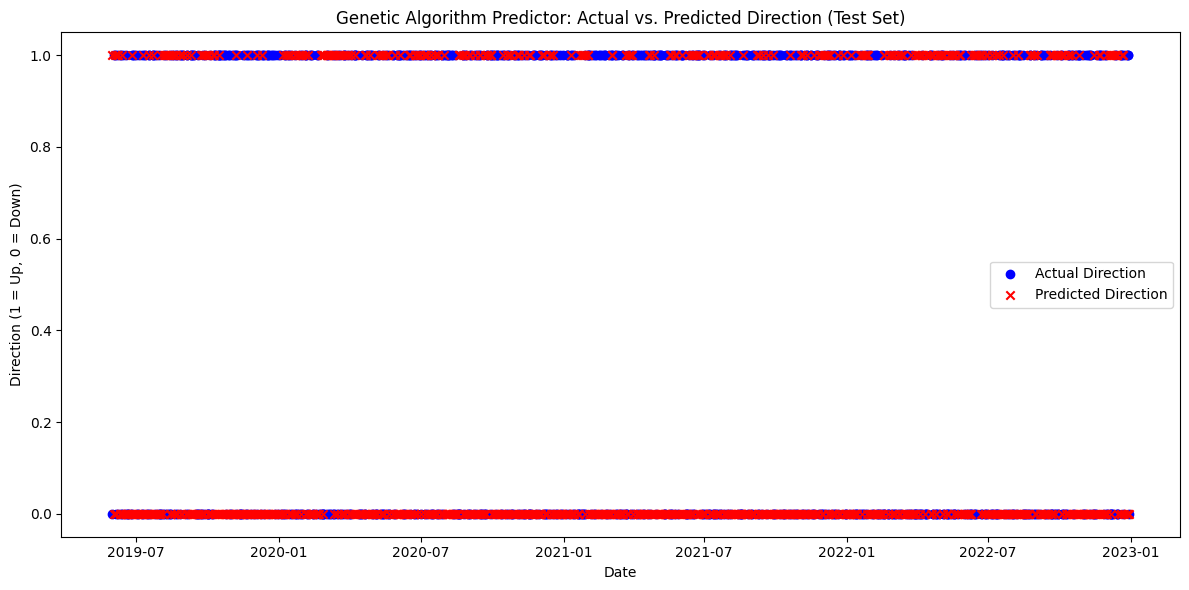


Running GA Experiment 3 with config: {'pop_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'crossover_rate': 0.7, 'tournament_size': 3}
Genetic Algorithm Predictor Results:
GA Best Training Accuracy (fitness): 53.29%
Test Directional Accuracy: 51.27%
Test Mean Squared Error: 0.4873
Test Mean Absolute Error: 0.4873


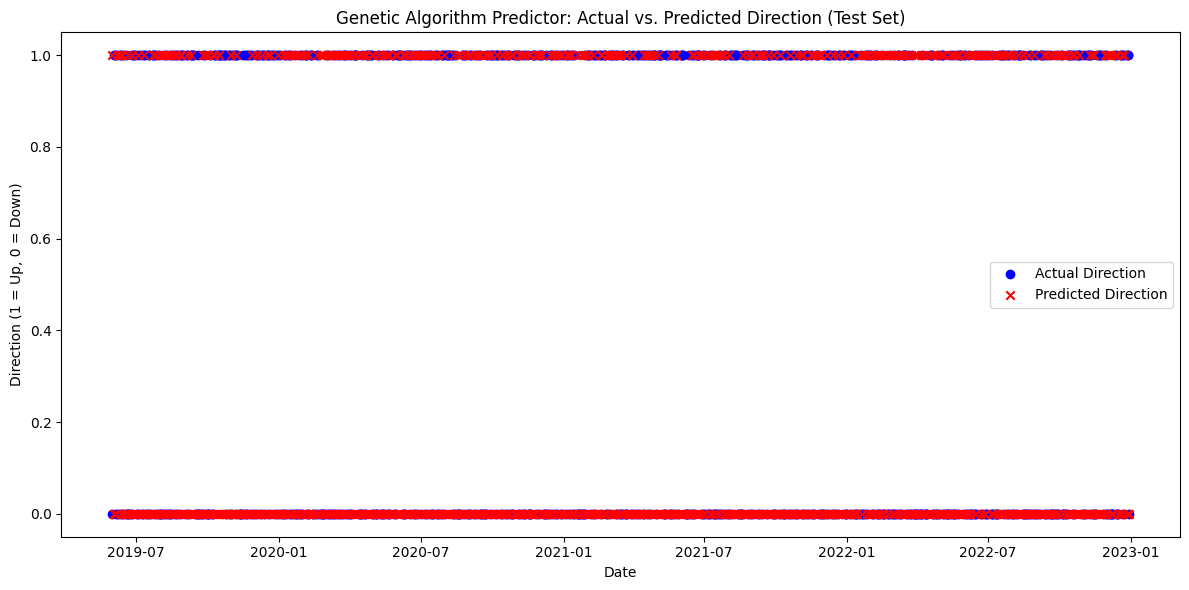


Running GA Experiment 4 with config: {'pop_size': 50, 'generations': 100, 'mutation_rate': 0.2, 'crossover_rate': 0.7, 'tournament_size': 3}
Genetic Algorithm Predictor Results:
GA Best Training Accuracy (fitness): 53.29%
Test Directional Accuracy: 51.27%
Test Mean Squared Error: 0.4873
Test Mean Absolute Error: 0.4873


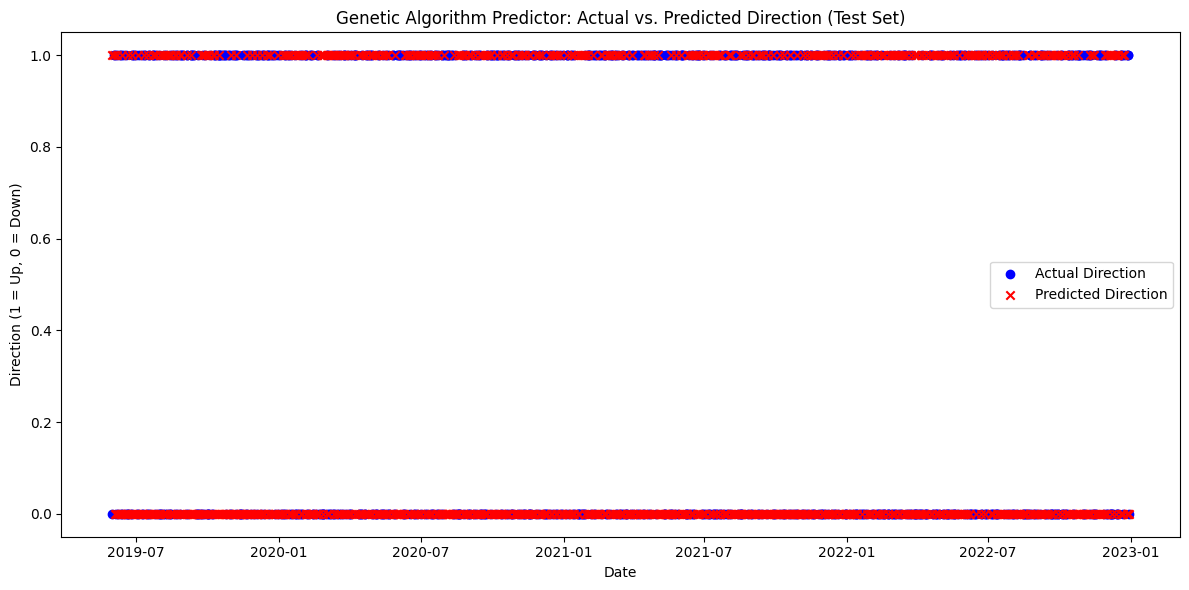


Running GA Experiment 5 with config: {'pop_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'crossover_rate': 0.9, 'tournament_size': 3}
Genetic Algorithm Predictor Results:
GA Best Training Accuracy (fitness): 53.40%
Test Directional Accuracy: 50.72%
Test Mean Squared Error: 0.4928
Test Mean Absolute Error: 0.4928


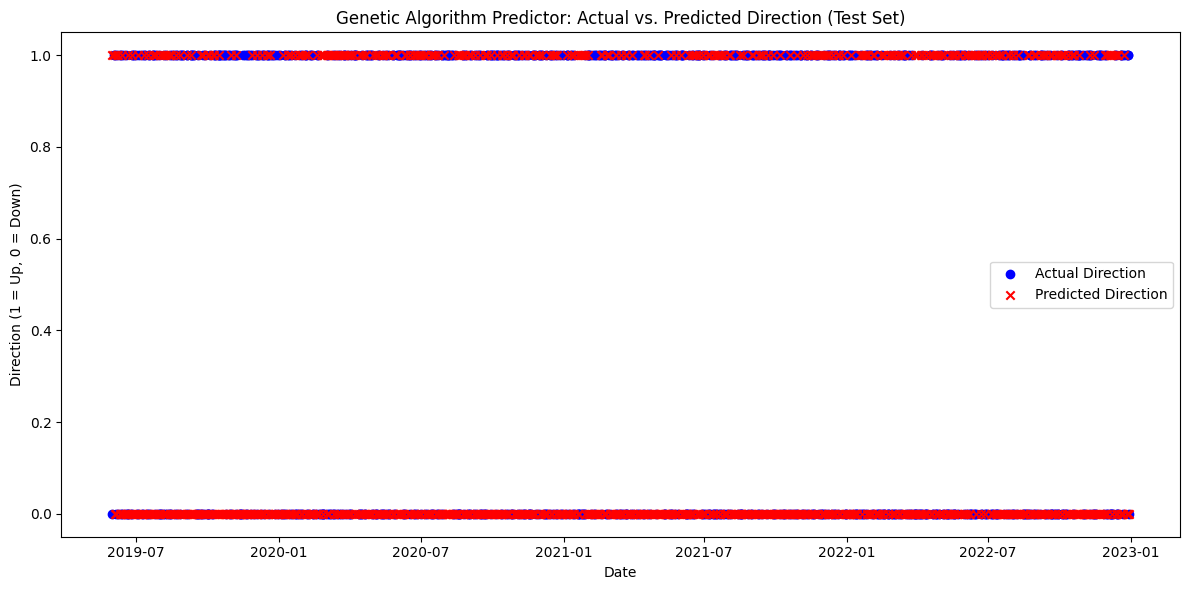


Genetic Algorithm Experiment Accuracies:
GA_exp_1_pop50_gen100_mut0.1_cross0.7: 51.38%
GA_exp_2_pop100_gen100_mut0.1_cross0.7: 49.28%
GA_exp_3_pop50_gen200_mut0.1_cross0.7: 51.27%
GA_exp_4_pop50_gen100_mut0.2_cross0.7: 51.27%
GA_exp_5_pop50_gen100_mut0.1_cross0.9: 50.72%


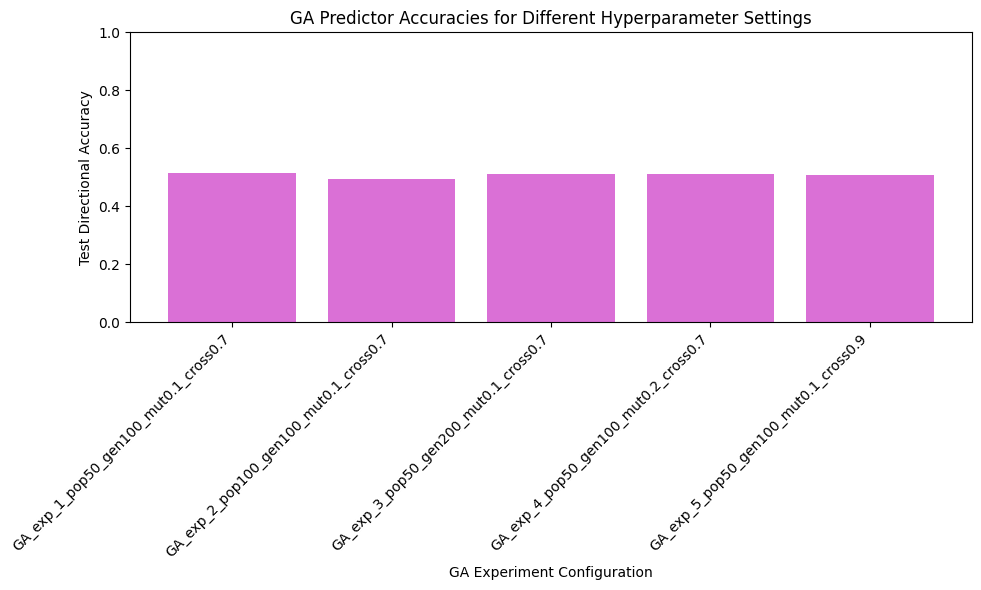

In [20]:
def main():
    try:
        # Load the data (ensure BAC.csv is in your working directory)
        data = pd.read_csv('BAC.csv')
        data['Date'] = pd.to_datetime(data['Date'])
        
        # Run GA experiments.
        ga_results = run_genetic_algorithm_experiments(data)
        
        # Plot accuracies.
        plot_ga_accuracies(ga_results)
        
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

### Ant Colony Optimization Algorithm

In [21]:
class ColonyOptimizationPredictor:
    def __init__(self, window_size=5, archive_size=20, num_ants=50, max_iter=100, q=0.5, xi=0.85, random_seed=None):
        """
        window_size: number of past returns used as features.
        archive_size: number of solutions to keep in the archive.
        num_ants: number of new candidate solutions generated per iteration.
        max_iter: number of iterations (generations) to run.
        q: parameter that controls the selection probability (a higher q gives more weight to top-ranked solutions).
        xi: parameter to scale the standard deviation for Gaussian sampling.
        random_seed: for reproducibility.
        """
        self.window_size = window_size
        self.archive_size = archive_size
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.q = q
        self.xi = xi
        self.best_solution = None
        self.best_fitness = -np.inf
        
        if random_seed is not None:
            np.random.seed(random_seed)
    
    def prepare_dataset(self, returns):
        """
        Build a dataset using a sliding window.
        Each sample is a vector of the previous `window_size` returns;
        the target is the direction (1 if next return > 0, else 0).
        """
        X = []
        y = []
        for i in range(self.window_size, len(returns)):
            X.append(returns[i-self.window_size:i])
            y.append(1 if returns[i] > 0 else 0)
        return np.array(X), np.array(y)
    
    def fitness(self, solution, X, y):
        """
        Evaluate a solution’s fitness as the directional accuracy on (X,y).
        The solution is a vector: first window_size elements are weights, and the last element is a bias.
        """
        weights = solution[:self.window_size]
        bias = solution[-1]
        preds = np.dot(X, weights) + bias
        predictions = (preds > 0).astype(int)
        return np.mean(predictions == y)
    
    def initialize_archive(self):
        """
        Initialize the archive with random solutions.
        Each solution is a vector of length (window_size+1) with values drawn uniformly from [-1,1].
        """
        archive = []
        for _ in range(self.archive_size):
            sol = np.random.uniform(-1, 1, size=self.window_size + 1)
            archive.append(sol)
        return archive
    
    def compute_weights(self):
        """
        Compute the selection probabilities for each archive solution based on their rank.
        We assume that the archive is already sorted in descending order of fitness.
        """
        ranks = np.arange(1, self.archive_size+1)  # 1 for best, etc.
        probabilities = np.exp(-self.q * (ranks-1) / (self.archive_size - 1))
        probabilities /= probabilities.sum()
        return probabilities
    
    def compute_sigma(self, archive):
        """
        Compute the standard deviation for each solution in the archive for each dimension.
        sigma_j for a solution is computed as:
            sigma_j = xi * sum_{k=1}^{archive_size} |x_k[j] - x_i[j]|/(archive_size - 1)
        This is done for each candidate in the archive.
        Returns an array of shape (archive_size, dimension).
        """
        archive = np.array(archive)
        m, d = archive.shape
        sigma = np.zeros((m, d))
        for i in range(m):
            # Compute differences with all other solutions for each dimension.
            diffs = np.abs(archive - archive[i])
            # Mean difference (avoid dividing by zero if m==1)
            sigma[i] = self.xi * (diffs.sum(axis=0) / (m - 1)) if m > 1 else np.ones(d) * self.xi
        return sigma
    
    def generate_candidates(self, archive):
        """
        Generate new candidate solutions.
        For each new candidate, first select an archive solution based on the computed probabilities,
        then sample from a Gaussian centered on that solution with standard deviation computed from the archive.
        """
        probabilities = self.compute_weights()
        sigma = self.compute_sigma(archive)
        new_candidates = []
        for _ in range(self.num_ants):
            # Select an archive solution index (roulette wheel selection)
            selected_idx = np.random.choice(np.arange(self.archive_size), p=probabilities)
            center = archive[selected_idx]
            std = sigma[selected_idx]
            candidate = np.random.normal(center, std)
            new_candidates.append(candidate)
        return new_candidates

    def evolve(self, X, y):
        """
        Run the ACOR evolution process.
        """
        # Initialize archive and evaluate fitness
        archive = self.initialize_archive()
        fitnesses = [self.fitness(sol, X, y) for sol in archive]
        # Sort archive by fitness (best first)
        archive = [sol for _, sol in sorted(zip(fitnesses, archive), key=lambda pair: pair[0], reverse=True)]
        best = archive[0]
        best_fit = self.fitness(best, X, y)
        
        for iteration in range(self.max_iter):
            # Generate new candidates
            candidates = self.generate_candidates(archive)
            # Evaluate new candidates
            candidates_fitness = [self.fitness(sol, X, y) for sol in candidates]
            # Merge archive and new candidates
            combined = archive + candidates
            combined_fitness = [self.fitness(sol, X, y) for sol in combined]
            # Sort combined list
            sorted_combined = [sol for _, sol in sorted(zip(combined_fitness, combined), key=lambda pair: pair[0], reverse=True)]
            # Keep the best archive_size solutions
            archive = sorted_combined[:self.archive_size]
            
            current_best = archive[0]
            current_best_fit = self.fitness(current_best, X, y)
            if current_best_fit > best_fit:
                best_fit = current_best_fit
                best = current_best.copy()
            # Optionally, print progress
            # print(f"Iteration {iteration+1}/{self.max_iter}: Best Fitness = {best_fit:.4f}")
        
        self.best_solution = best
        self.best_fitness = best_fit

    def predict(self, X):
        """
        Predict market direction using the best solution found.
        """
        if self.best_solution is None:
            raise ValueError("Colony Optimization has not been run. Call evolve() first.")
        weights = self.best_solution[:self.window_size]
        bias = self.best_solution[-1]
        preds = np.dot(X, weights) + bias
        return (preds > 0).astype(int)

def prepare_data(data):
    """
    Clean the data, convert Date column, set as index, and compute daily returns.
    """
    data = data.copy()
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    data['Returns'] = data['Adj Close'].pct_change()
    data = data.dropna()
    return data

In [22]:
def evaluate_colony_optimization_predictions(data, window_size=5, test_size=0.2,
                                             archive_size=20, num_ants=50, max_iter=100,
                                             q=0.5, xi=0.85, random_seed=None):
    """
    Evaluate the colony optimization predictor on the provided data.
    Splits the data into training and testing sets, evolves the colony optimizer on the training set,
    and then evaluates directional accuracy on the test set.
    Also plots a scatter plot (dots) for actual vs. predicted directions.
    """
    df = prepare_data(data)
    returns = df['Returns'].values
    
    # Build dataset using sliding window.
    predictor = ColonyOptimizationPredictor(window_size=window_size, archive_size=archive_size,
                                              num_ants=num_ants, max_iter=max_iter, q=q, xi=xi,
                                              random_seed=random_seed)
    X, y = predictor.prepare_dataset(returns)
    
    # Split into training and test sets.
    split_idx = int(len(X) * (1 - test_size))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]
    
    # Evolve the colony optimizer on the training set.
    predictor.evolve(X_train, y_train)
    
    # Predict on test set.
    predictions = predictor.predict(X_test)
    
    # Evaluation metrics.
    accuracy = accuracy_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    print("Colony Optimization Predictor Results:")
    print(f"Best Training Accuracy (Fitness): {predictor.best_fitness:.2%}")
    print(f"Test Directional Accuracy: {accuracy:.2%}")
    print(f"Test Mean Squared Error: {mse:.4f}")
    print(f"Test Mean Absolute Error: {mae:.4f}")
    
    # Adjust test dates for the sliding window offset.
    test_dates = df.iloc[window_size + split_idx:].index
    plt.figure(figsize=(12, 6))
    plt.scatter(test_dates, y_test, label='Actual Direction', color='blue', marker='o')
    plt.scatter(test_dates, predictions, label='Predicted Direction', color='red', marker='x')
    plt.xlabel("Date")
    plt.ylabel("Direction (1 = Up, 0 = Down)")
    plt.title("Colony Optimization Predictor: Actual vs. Predicted Direction (Test Set)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'mse': mse,
        'mae': mae,
        'predictions': predictions,
        'actual': y_test,
        'best_solution': predictor.best_solution,
        'co_config': {
            'window_size': window_size,
            'archive_size': archive_size,
            'num_ants': num_ants,
            'max_iter': max_iter,
            'q': q,
            'xi': xi
        }
    }

In [23]:
def run_colony_optimization_experiments(data):
    """
    Runs experiments for the colony optimization predictor using different hyperparameter configurations.
    Returns a dictionary with results for each configuration.
    """
    configs = [
        # Each config is a dict of hyperparameters.
        {'archive_size': 20, 'num_ants': 50, 'max_iter': 100, 'q': 0.5, 'xi': 0.85},
        {'archive_size': 30, 'num_ants': 50, 'max_iter': 100, 'q': 0.5, 'xi': 0.85},
        {'archive_size': 20, 'num_ants': 100, 'max_iter': 100, 'q': 0.5, 'xi': 0.85},
        {'archive_size': 20, 'num_ants': 50, 'max_iter': 200, 'q': 0.5, 'xi': 0.85},
        {'archive_size': 20, 'num_ants': 50, 'max_iter': 100, 'q': 0.7, 'xi': 0.85},
    ]
    
    results = {}
    for i, config in enumerate(configs):
        print("\n======================================================")
        print(f"Running Colony Optimization Experiment {i+1} with config: {config}")
        result = evaluate_colony_optimization_predictions(
            data,
            window_size=5,
            test_size=0.2,
            archive_size=config['archive_size'],
            num_ants=config['num_ants'],
            max_iter=config['max_iter'],
            q=config['q'],
            xi=config['xi'],
            random_seed=42
        )
        key = f"CO_exp_{i+1}_arch{config['archive_size']}_ants{config['num_ants']}_iter{config['max_iter']}_q{config['q']}_xi{config['xi']}"
        results[key] = result
    return results

def plot_co_accuracies(results):
    """
    Print and plot the test directional accuracies for all colony optimization experiments.
    """
    model_names = list(results.keys())
    accuracies = [results[k]['accuracy'] for k in model_names]
    
    print("\nColony Optimization Experiment Accuracies:")
    for name, acc in zip(model_names, accuracies):
        print(f"{name}: {acc:.2%}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='mediumseagreen')
    plt.ylabel("Test Directional Accuracy")
    plt.xlabel("Colony Optimization Experiment Configurations")
    plt.title("Colony Optimization Predictor Accuracies")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


Running Colony Optimization Experiment 1 with config: {'archive_size': 20, 'num_ants': 50, 'max_iter': 100, 'q': 0.5, 'xi': 0.85}
Colony Optimization Predictor Results:
Best Training Accuracy (Fitness): 53.59%
Test Directional Accuracy: 50.39%
Test Mean Squared Error: 0.4961
Test Mean Absolute Error: 0.4961


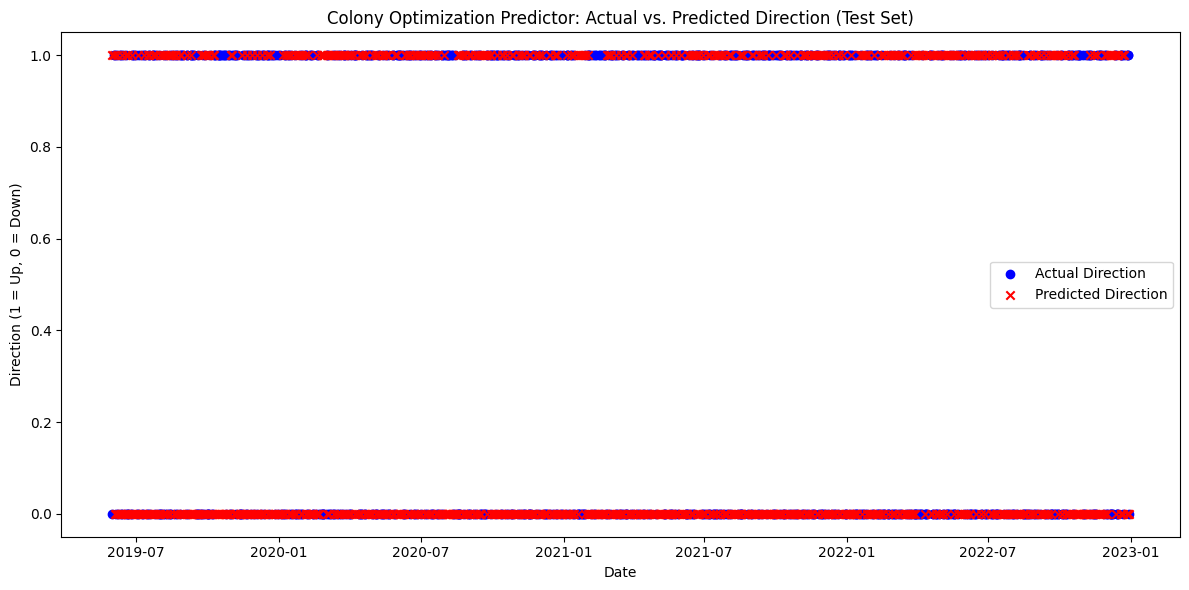


Running Colony Optimization Experiment 2 with config: {'archive_size': 30, 'num_ants': 50, 'max_iter': 100, 'q': 0.5, 'xi': 0.85}
Colony Optimization Predictor Results:
Best Training Accuracy (Fitness): 53.62%
Test Directional Accuracy: 50.28%
Test Mean Squared Error: 0.4972
Test Mean Absolute Error: 0.4972


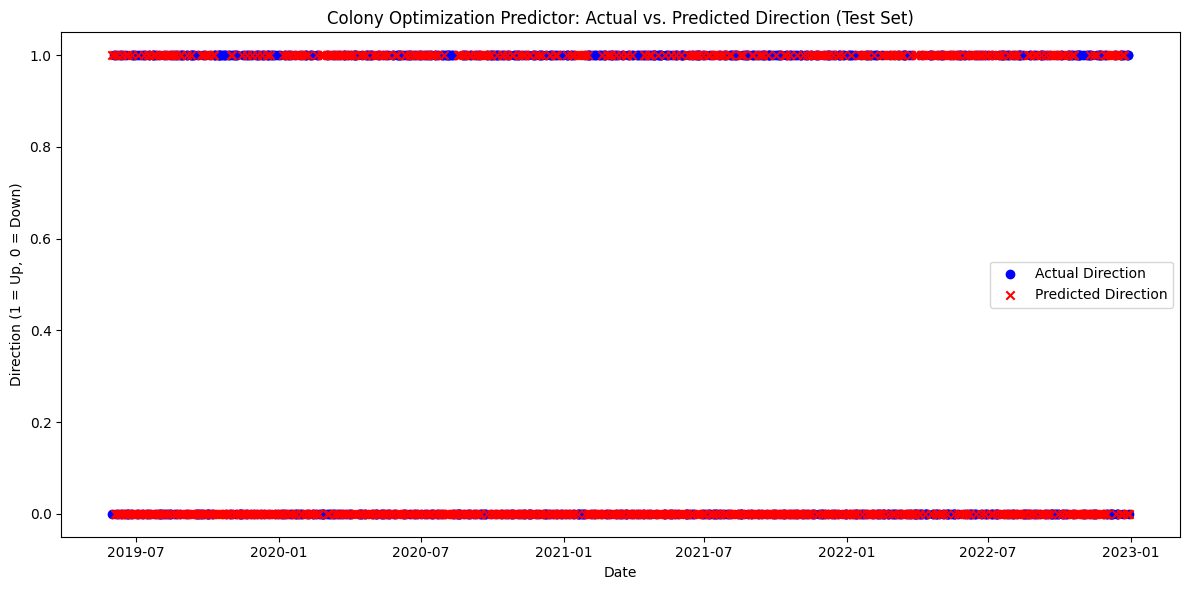


Running Colony Optimization Experiment 3 with config: {'archive_size': 20, 'num_ants': 100, 'max_iter': 100, 'q': 0.5, 'xi': 0.85}
Colony Optimization Predictor Results:
Best Training Accuracy (Fitness): 53.12%
Test Directional Accuracy: 50.83%
Test Mean Squared Error: 0.4917
Test Mean Absolute Error: 0.4917


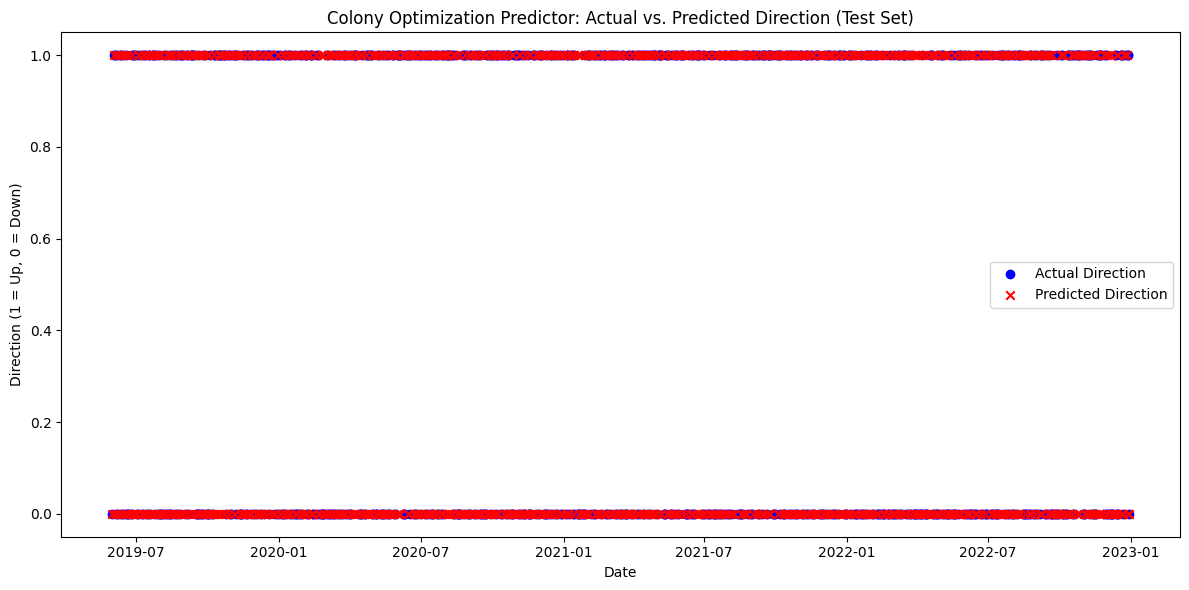


Running Colony Optimization Experiment 4 with config: {'archive_size': 20, 'num_ants': 50, 'max_iter': 200, 'q': 0.5, 'xi': 0.85}
Colony Optimization Predictor Results:
Best Training Accuracy (Fitness): 53.65%
Test Directional Accuracy: 50.28%
Test Mean Squared Error: 0.4972
Test Mean Absolute Error: 0.4972


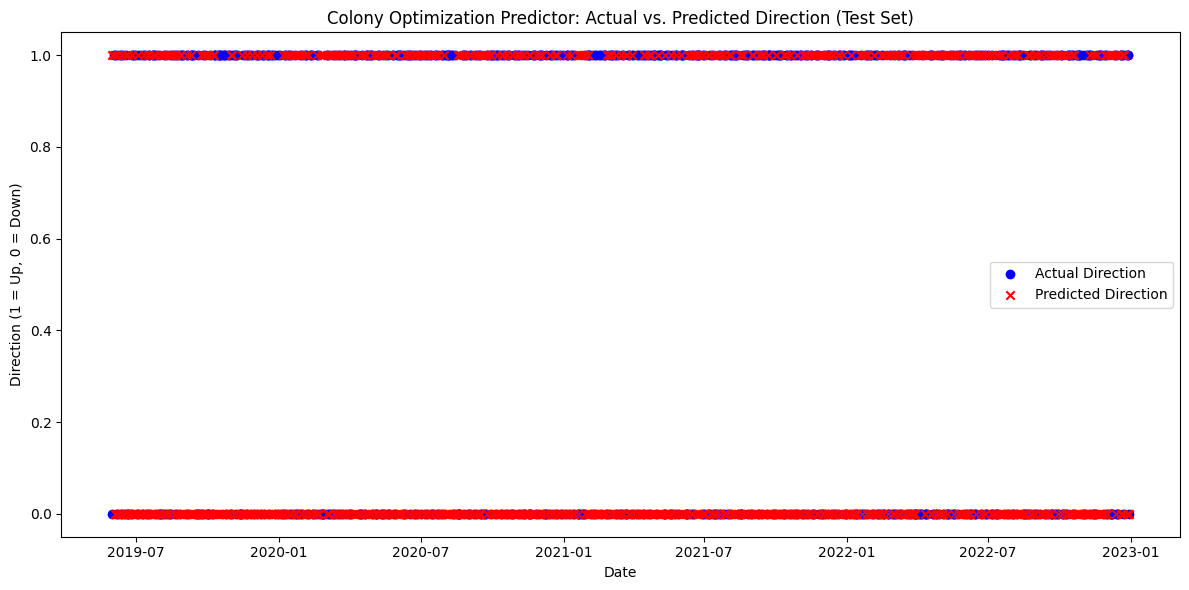


Running Colony Optimization Experiment 5 with config: {'archive_size': 20, 'num_ants': 50, 'max_iter': 100, 'q': 0.7, 'xi': 0.85}
Colony Optimization Predictor Results:
Best Training Accuracy (Fitness): 53.76%
Test Directional Accuracy: 50.28%
Test Mean Squared Error: 0.4972
Test Mean Absolute Error: 0.4972


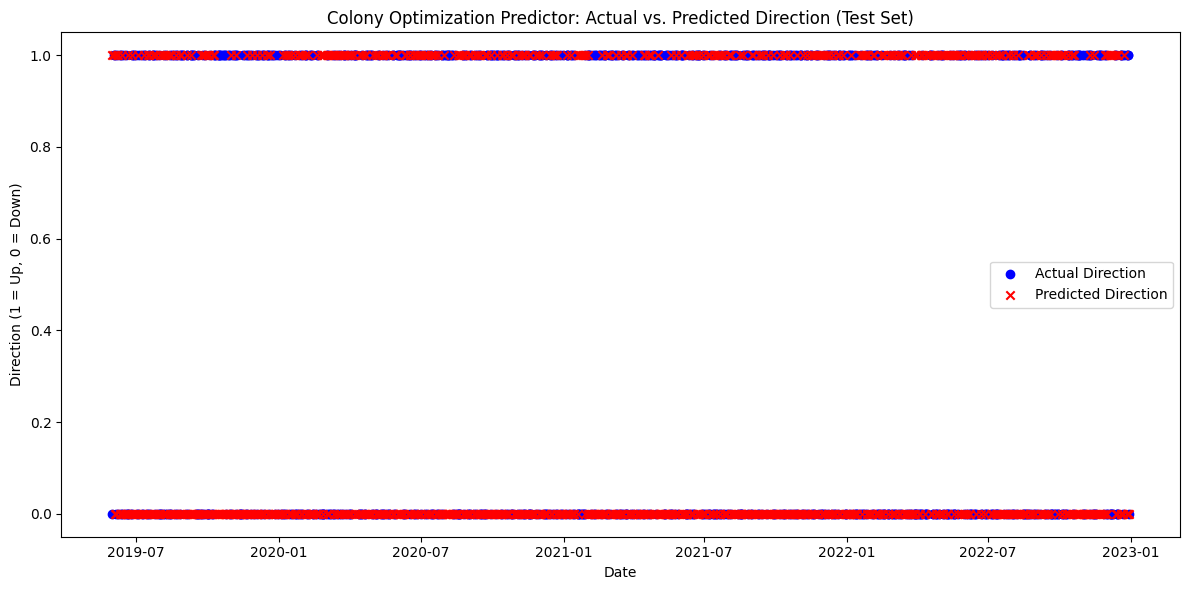


Colony Optimization Experiment Accuracies:
CO_exp_1_arch20_ants50_iter100_q0.5_xi0.85: 50.39%
CO_exp_2_arch30_ants50_iter100_q0.5_xi0.85: 50.28%
CO_exp_3_arch20_ants100_iter100_q0.5_xi0.85: 50.83%
CO_exp_4_arch20_ants50_iter200_q0.5_xi0.85: 50.28%
CO_exp_5_arch20_ants50_iter100_q0.7_xi0.85: 50.28%


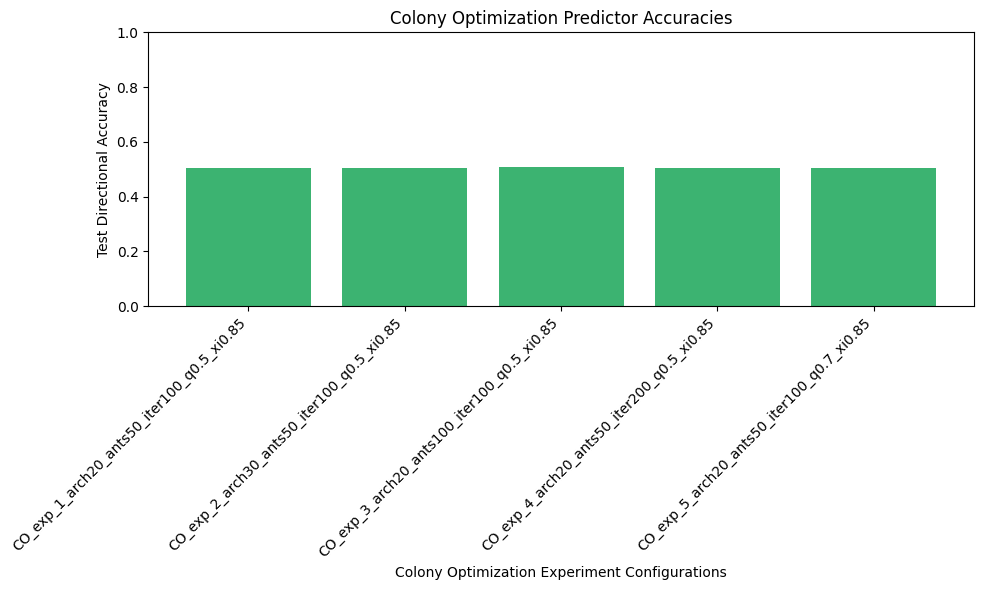

In [24]:
try:
    # Load data (ensure BAC.csv is available in the working directory)
    data = pd.read_csv('BAC.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Run experiments.
    co_results = run_colony_optimization_experiments(data)
    
    # Plot experiment accuracies.
    plot_co_accuracies(co_results)
    
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()